In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

from PIL import Image

In [ ]:
for dirname, _, filenames in os.walk('/root/Downloads/chest-xray-pneumonia/chest_xray/chest_xrays/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
datadir = '/root/Downloads/chest-xray-pneumonia/chest_xray/chest_xrays'
traindir = datadir + '/train/'
testdir = datadir + '/test/'
valdir = datadir + '/val/'

In [3]:
# Inititiate lists
categories = []
img_categories = []
n_train = []
n_test = []
pixel_height = []
pixel_width = []

# Iterate through train and test folder
for i in os.listdir(traindir):
    if not i.startswith('.'):
        categories.append(i)

        # Obtain the total number of image per train, test set
        train_imgs = os.listdir(traindir + i)
        test_imgs = os.listdir(testdir + i)
        n_train.append(len(train_imgs))
        n_test.append(len(test_imgs))

        # Check the image dimensions of the train set
        for j in train_imgs:
            if not j.startswith('.'):
                img_categories.append(i)
                img = Image.open(traindir + i + '/' + j)
                img_array = np.array(img)
                pixel_height.append(img_array.shape[0])
                pixel_width.append(img_array.shape[1])

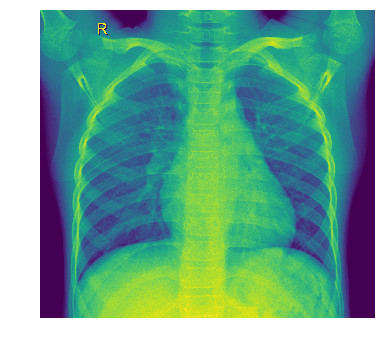

In [4]:
# We look at indivual sample of the images (Normal)

def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

x = Image.open(traindir + 'NORMAL/NORMAL2-IM-1258-0001-0001.jpeg')
np.array(x).shape
imshow(x)

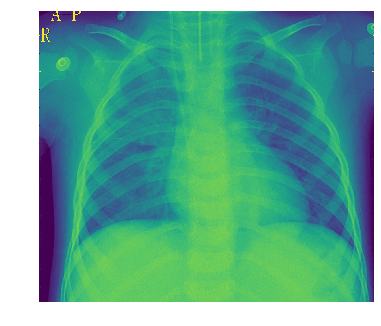

In [5]:
# We look at indivual sample of the images (Pneumonia)
y = Image.open(traindir + 'PNEUMONIA/person1709_bacteria_4524.jpeg')
np.array(y).shape
imshow(y)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

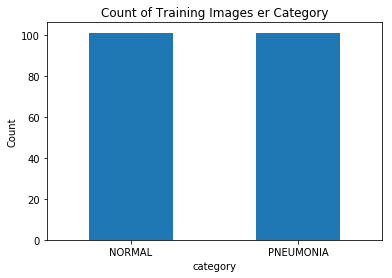

In [6]:
# Plot the distribution of train and test set
balance_df = pd.DataFrame({'category': categories, 'n_train': n_train, 'n_test': n_test}).sort_values('category')

# We sort and count the values per category and plot as a bar chart
balance_df.set_index('category')['n_train'].plot.bar()
plt.ylabel('Count')
plt.title('Count of Training Images er Category')
plt.xticks(rotation = 0)

In [7]:
# Now we need to check for the dimension of the individual images
image_df = pd.DataFrame({
    'category': img_categories,
    'height': pixel_height,
    'width': pixel_width
})

image_df.head()

,category,height,width
0,PNEUMONIA,728,1240
1,PNEUMONIA,624,1016
2,PNEUMONIA,704,1184
3,PNEUMONIA,1224,1712
4,PNEUMONIA,1256,1800


Text(0.5, 1.0, 'Average Size Distribution')

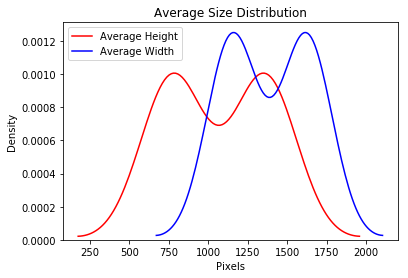

In [8]:
# We see that the sizes of the images. We need to trim down to a standard size
# But first we need to look at the distribution.

# We look into the density (occurence) per pixel position
img_dsc = image_df.groupby('category').mean()
sns.kdeplot(img_dsc['height'], label='Average Height', color = 'r')
sns.kdeplot(img_dsc['width'], label='Average Width', color = 'b')
plt.xlabel('Pixels')
plt.ylabel('Density')
plt.title('Average Size Distribution')

In [9]:
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),

    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [10]:
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, sampler
batch_size = 10

data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test']),
    'val':
    datasets.ImageFolder(root=valdir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=16, shuffle=False)
}

In [11]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([10, 3, 224, 224]), torch.Size([10]))

In [12]:
n_iters = 10
num_epochs = n_iters / (len(dataloaders['train']) / batch_size)
num_epochs = int(num_epochs)

In [13]:
num_epochs

5

In [14]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(32 * 56 * 56, 2) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Max pool 2 
        out = self.maxpool2(out)
        
        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out

In [15]:
model = CNNModel()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [16]:
print(model.parameters())

print(len(list(model.parameters())))

# Convolution 1: 16 Kernels
print(list(model.parameters())[0].size())

# Convolution 1 Bias: 16 Kernels
print(list(model.parameters())[1].size())

# Convolution 2: 32 Kernels with depth = 16
print(list(model.parameters())[2].size())

# Convolution 2 Bias: 32 Kernels with depth = 16
print(list(model.parameters())[3].size())

# Fully Connected Layer 1
print(list(model.parameters())[4].size())

# Fully Connected Layer Bias
print(list(model.parameters())[5].size())

<generator object Module.parameters at 0x7f0b0606f138>
6
torch.Size([16, 3, 5, 5])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([2, 100352])
torch.Size([2])


In [17]:
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloaders['train']):
        # Load images
        images = images.requires_grad_()
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 10 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in dataloaders['test']:
                # Load images
                images = images.requires_grad_()
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 10. Loss: 0.6544424295425415. Accuracy: 75
Iteration: 20. Loss: 0.43144410848617554. Accuracy: 69
Iteration: 30. Loss: 0.6844228506088257. Accuracy: 57
Iteration: 40. Loss: 0.4338437020778656. Accuracy: 64
Iteration: 50. Loss: 0.2549433708190918. Accuracy: 60
Iteration: 60. Loss: 0.4774232804775238. Accuracy: 78
Iteration: 70. Loss: 0.2914363741874695. Accuracy: 78
Iteration: 80. Loss: 0.3872776925563812. Accuracy: 78
Iteration: 90. Loss: 0.20244702696800232. Accuracy: 69
Iteration: 100. Loss: 0.19345444440841675. Accuracy: 80


In [18]:
import os

x = []
for i in range(len(data['val'])):
     for images, labels in dataloaders['val']:
         images1 = images.requires_grad_()
         outputs1 = model(images)
         _, predicted1 = torch.max(outputs1.data, 1)
         sample_fname, _ = dataloaders['val'].dataset.samples[i]
         sample_fname1 = os.path.basename(sample_fname)
         x.append(sample_fname1)

In [19]:
y = predicted1.tolist()

In [20]:
import pandas as pd
df = pd.DataFrame(
    {'File_Name': x,
     'Prediction': y
    })

In [21]:
df.to_csv('Sample_Submission.csv', index=False)